# COURSE: A deep understanding of deep learning
## SECTION: Convolution and transformations
### LECTURE: Creating and using custom DataSets
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [ ]:
# FYI, review paper on data augmentation in DL:
# https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

In [1]:
# import libraries
import numpy as np
import torch

# import transformations and dataset/loader
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import the data

In [5]:
# import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

# extract only the first 8
labels = labels[:8]
data   = data[:8]

# Technically not necessary as when we import it to tensors, it will be normalized
dataNorm = data / np.max(data.numpy())

# reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

# check sizes
print(dataNorm.shape)
print(labels.shape)

# convert to torch tensor format
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

torch.Size([8, 1, 28, 28])
torch.Size([8])


/tmp/ipykernel_561802/1637039651.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataT   = torch.tensor( dataNorm ).float()
/tmp/ipykernel_561802/1637039651.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labelsT = torch.tensor( labels ).long()


# Create a new class to create our custom dataset type

In [7]:
# My custom dataset class is modeled after the official class
help(torch.utils.data.TensorDataset)

Help on class TensorDataset in module torch.utils.data.dataset:

class TensorDataset(Dataset)
 |  TensorDataset(*tensors: torch.Tensor) -> None
 |
 |  Dataset wrapping tensors.
 |
 |  Each sample will be retrieved by indexing tensors along the first dimension.
 |
 |  Args:
 |      *tensors (Tensor): tensors that have the same size of the first dimension.
 |
 |  Method resolution order:
 |      TensorDataset
 |      Dataset
 |      typing.Generic
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __getitem__(self, index)
 |
 |  __init__(self, *tensors: torch.Tensor) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  __len__(self)
 |
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |
 |  __annotations__ = {'tensors': typing.Tuple[torch.Tensor, ...]}
 |
 |  __orig_bases__ = (torch.utils.data.dataset.Dataset[typing.Tuple[torch....
 |
 |  __parameters__ = ()
 |
 |  ------------

In [8]:
class customDataset(Dataset):
  def __init__(self, tensors, transform=None):

    # check that sizes of data and labels match
    assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"
    
    # assign inputs
    self.tensors   = tensors
    self.transform = transform

  # what to do when someone wants and item from the dataset
  def __getitem__(self, index): 

    # return transformed version of x if there are transforms
    if self.transform:
      x = self.transform(self.tensors[0][index])
    else:
      x = self.tensors[0][index]

    # and return label
    y = self.tensors[1][index]

    return x,y # return the (data,label) tuple

  def __len__(self):
    return self.tensors[0].size(0)

# data -> dataset -> dataloader

In [9]:
# Note: several transforms work only on PIL-format data, so it's common to transform
#       to PIL, apply transformations, then transform back to tensor.

# create a list of transforms to apply to the image
imgtrans = T.Compose([ 
                      T.ToPILImage(),
                      T.RandomVerticalFlip(p=.5),
                      # T.RandomRotation(90), 
                      T.ToTensor()
                       ])

In [10]:
# now convert the data into datasets and then dataloaders

# convert into PyTorch Datasets
# NOTE: we have no test data here, but you should apply the same transformations to the test data
train_data = customDataset((dataT,labelsT),imgtrans)

# translate into dataloader objects
dataLoaded = DataLoader(train_data,batch_size=8,shuffle=False)

In [11]:
type(train_data)

__main__.customDataset

# Let's see the effects!

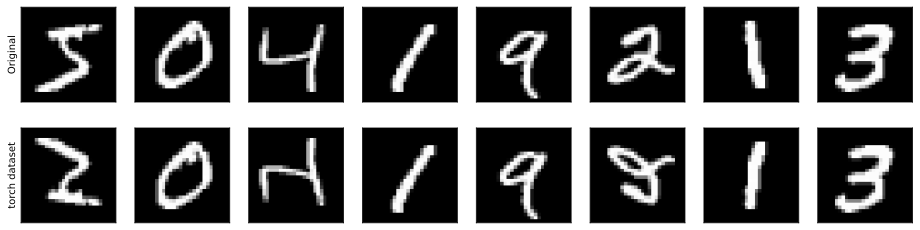

In [13]:
# import data from the dataloader, just like during training
X,y = next(iter(dataLoaded))


# create a figure
fig,axs = plt.subplots(2,8,figsize=(16,4))


# loop over images in the dataset
for i in range(8):

  # draw images
  axs[0,i].imshow(dataT[i,0,:,:].detach(),cmap='gray')
  axs[1,i].imshow(X[i,0,:,:].detach(),cmap='gray')

  # some niceties
  for row in range(2):
    axs[row,i].set_xticks([])
    axs[row,i].set_yticks([])

# row labels
axs[0,0].set_ylabel('Original')
axs[1,0].set_ylabel('torch dataset')

plt.show()

In [14]:
# Important to know: we haven't actually increased the amount of data
len(train_data)

8